# 1. Exploratory Data Analysis (EDA)

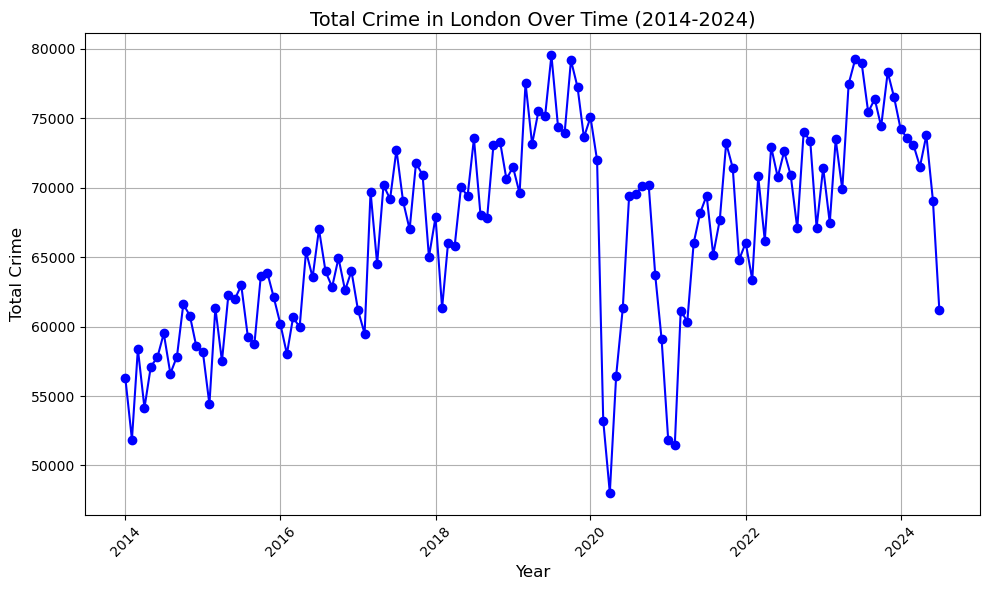

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load crime data
crime_data = pd.read_csv('Data/combined_crime_data.csv')

# Summing up crime data across all wards for each month to get the total crime count for London
crime_data_sum = crime_data.iloc[:, 3:].sum(axis=0)

# Extract the year-month labels from column names and convert them to a time index
time_index = pd.to_datetime(crime_data_sum.index, format='%Y%m')

# Plotting the total crime trends over time
plt.figure(figsize=(10,6))
plt.plot(time_index, crime_data_sum, marker='o', linestyle='-', color='b')
plt.title('Total Crime in London Over Time (2014-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Crime', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## Highlighting the 2 unusual spikes (Covid-19 Lockdowns in London)

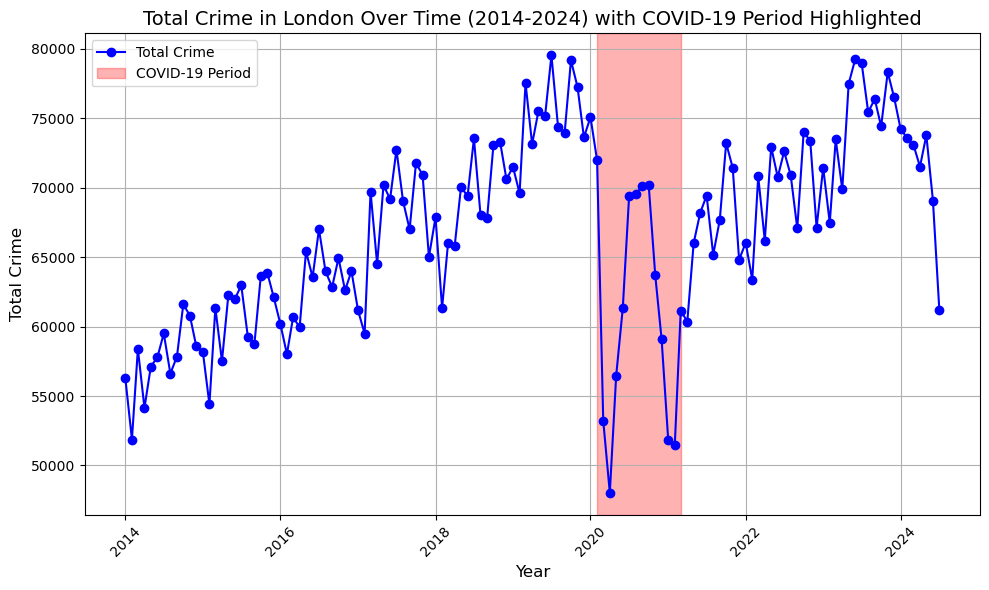

In [3]:
# COVID-19 period for highlighting
covid_start = pd.to_datetime("2020-02", format='%Y-%m')
covid_end = pd.to_datetime("2021-03", format='%Y-%m')

# Plot the total crime trend over time with the COVID-19 period highlighted
plt.figure(figsize=(10,6))
plt.plot(time_index, crime_data_sum, marker='o', linestyle='-', color='b', label='Total Crime')
plt.axvspan(covid_start, covid_end, color='r', alpha=0.3, label='COVID-19 Period')

plt.title('Total Crime in London Over Time (2014-2024) with COVID-19 Period Highlighted', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Crime', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


### Filtering out the data during Covid-19

In [4]:
#Filter out the COVID-19 period (February 2020 to March 2021)
filtered_crime_data = crime_data.drop(columns=[col for col in crime_data.columns if "202002" <= col <= "202103"])

# Recalculate the total crime trends excluding the COVID-19 period
filtered_crime_data_sum = filtered_crime_data.iloc[:, 3:].sum(axis=0)

# Extract the updated year-month labels and convert to time index
filtered_time_index = pd.to_datetime(filtered_crime_data_sum.index, format='%Y%m')


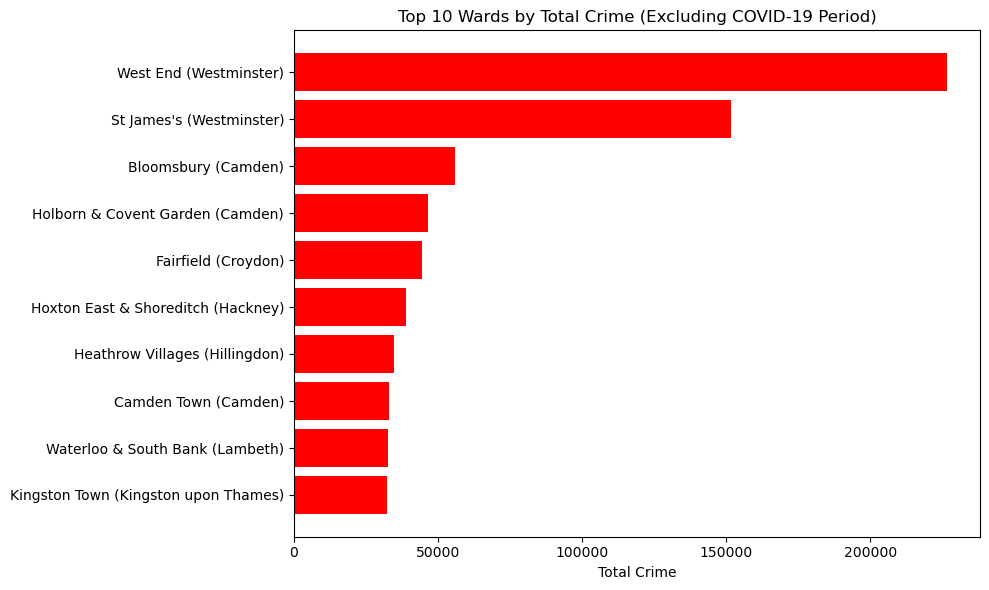

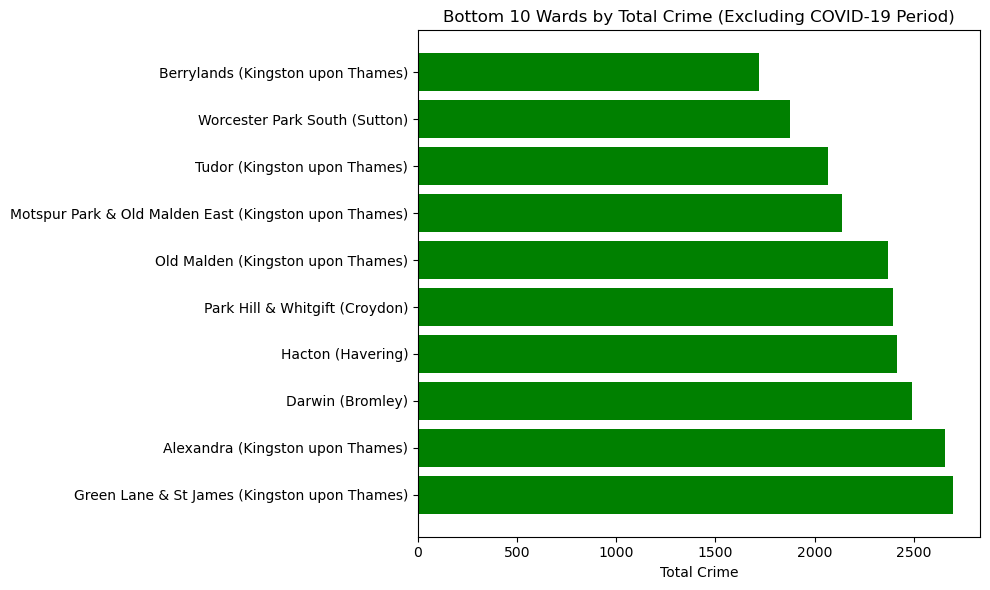

In [5]:
# Calculate total crime for each ward by summing across all months (excluding the COVID-19 period)
filtered_crime_by_ward = filtered_crime_data.iloc[:, 3:].sum(axis=1)

# Add the total crime per ward as a new column in the original data
filtered_crime_data['TotalCrime'] = filtered_crime_by_ward

# Sort wards by total crime (descending order) to identify the top and bottom wards
top_wards = filtered_crime_data[['WardName', 'LookUp_BoroughName', 'TotalCrime']].sort_values(by='TotalCrime', ascending=False).head(10)
bottom_wards = filtered_crime_data[['WardName', 'LookUp_BoroughName', 'TotalCrime']].sort_values(by='TotalCrime', ascending=True).head(10)


# Visualization of the top and bottom wards by total crime with borough names in brackets

# Top 10 Wards
plt.figure(figsize=(10,6))
plt.barh(top_wards['WardName'] + " (" + top_wards['LookUp_BoroughName'] + ")", top_wards['TotalCrime'], color='red')
plt.xlabel('Total Crime')
plt.title('Top 10 Wards by Total Crime (Excluding COVID-19 Period)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

# Bottom 10 Wards
plt.figure(figsize=(10,6))
plt.barh(bottom_wards['WardName'] + " (" + bottom_wards['LookUp_BoroughName'] + ")", bottom_wards['TotalCrime'], color='green')
plt.xlabel('Total Crime')
plt.title('Bottom 10 Wards by Total Crime (Excluding COVID-19 Period)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


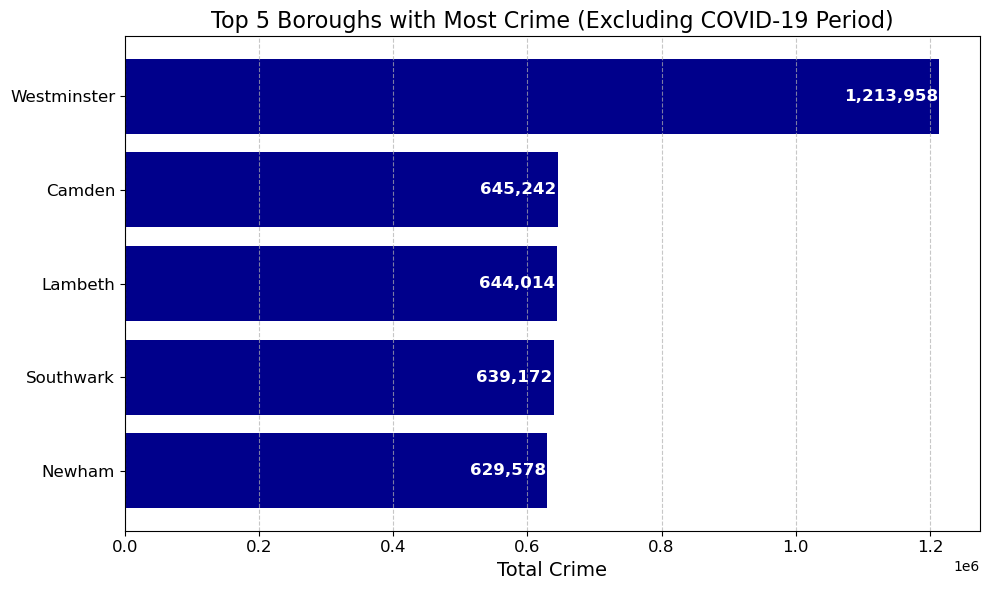

In [6]:
# Group the crime data by borough 
total_crime_by_borough = filtered_crime_data.groupby('LookUp_BoroughName').sum(numeric_only=True).sum(axis=1)

# Sort boroughs by total crime and select the top 5
top_5_boroughs = total_crime_by_borough.sort_values(ascending=False).head(5)

# Bar graph for top 5 boroughs with most crime
plt.figure(figsize=(10,6))

bars = plt.barh(top_5_boroughs.index, top_5_boroughs.values, color='darkblue')

for bar in bars:
    plt.text(bar.get_width() - 2000, bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width()):,}', 
             va='center', ha='right', color='white', fontsize=12, weight='bold')

plt.xlabel('Total Crime', fontsize=14)
plt.title('Top 5 Boroughs with Most Crime (Excluding COVID-19 Period)', fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


### Visualizing Total Crime by Ward

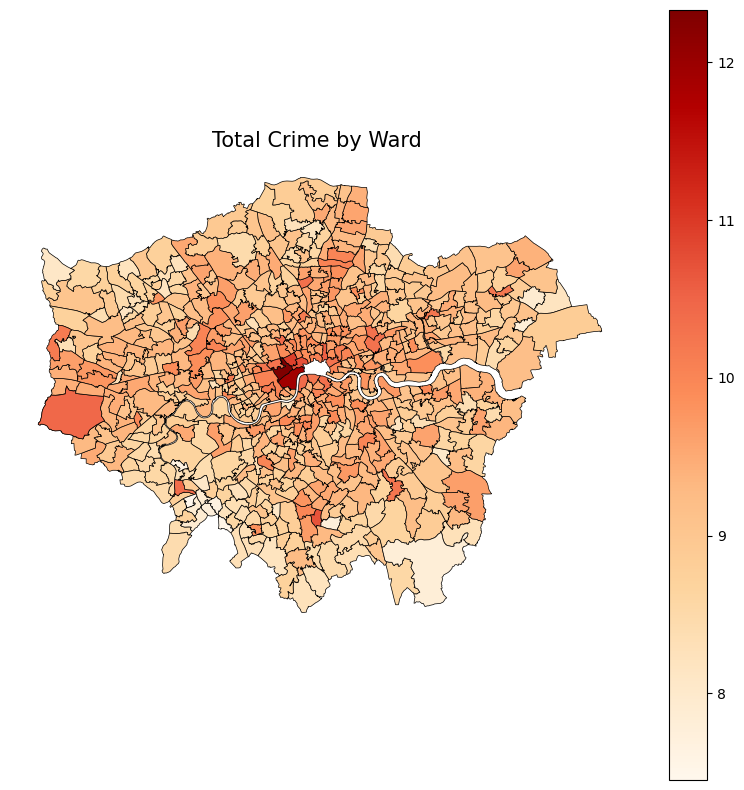

In [7]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

shapefile_path = 'data/Map/england_wd_2022_bgc.shp'  
geospatial_data = gpd.read_file(shapefile_path)

geospatial_data['geometry'] = geospatial_data['geometry'].simplify(tolerance=0.001, preserve_topology=True)

# Merge geospatial data with the summed crime data
crime_merged_data = geospatial_data.merge(filtered_crime_data[['WardCode', 'TotalCrime']], left_on='wd22cd', right_on='WardCode', how='left')

# Apply logarithmic scaling to the crime data to reduce the skew
crime_merged_data['log_Total_Crime_Sum'] = np.log1p(crime_merged_data['TotalCrime']) 

# Plot the map with the log-transformed crime data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
crime_merged_data.plot(column='log_Total_Crime_Sum', cmap='OrRd', linewidth=0.5, edgecolor='Black', legend=True, ax=ax)

ax.set_title('Total Crime by Ward ', fontsize=15)
ax.set_axis_off()

plt.show()

